In [2]:
# Import libraries
import numpy as np
import pandas as pd
from google.cloud import bigquery #pip install google-cloud-bigquery for SQL
# Import libraries for TM
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
#pyLDAvis documentation: 1) https://pyldavis.readthedocs.io/en/latest/readme.html; 2) https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Import libraries for Topic Modelling
import warnings
warnings.filterwarnings("ignore")

from nltk.tokenize import word_tokenize
from gensim.models.coherencemodel import CoherenceModel
import en_core_web_md # download python -m spacy download en_core_web_md
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [3]:
project='' #Put your project id

In [4]:
# Initialize a BigQuery Client
client=bigquery.Client(project)

In [5]:
# Construct a reference to a dataset 
dataset_ref=client.dataset('bbc_news', project='bigquery-public-data')

In [6]:
# Fetch the dataset
dataset=client.get_dataset(dataset_ref)

In [7]:
# Construct a reference to a table
table_ref=dataset_ref.table('fulltext')
table=client.get_table(table_ref)

In [12]:
# Put the table to a DataFrame and preview
df = client.list_rows(table).to_dataframe()
df.head(10)

,body,title,filename,category
0,The global web blog community is being called ...,Global blogger action day called,bbc/tech/016.txt,tech
1,"The ""digital divide"" between rich and poor nat...",Global digital divide 'narrowing',bbc/tech/033.txt,tech
2,The current slew of sports games offers unpara...,Sporting rivals go to extra time,bbc/tech/056.txt,tech
3,Writing a Microsoft Word document can be a dan...,Warning over Windows Word files,bbc/tech/086.txt,tech
4,"Aid workers trying to house, feed and clothe m...",Satellite mapping aids Darfur relief,bbc/tech/223.txt,tech
5,DVDs will be harder to copy thanks to new anti...,DVD copy protection strengthened,bbc/tech/326.txt,tech
6,UK mobile owners continue to break records wit...,Text message record smashed again,bbc/tech/372.txt,tech
7,Internet TV has been talked about since the st...,TV's future down the phone line,bbc/tech/394.txt,tech
8,Intel has unveiled research that could mean da...,Intel unveils laser breakthrough,bbc/tech/019.txt,tech
9,BBC Sport unveils its new analysis tool Piero ...,Piero gives rugby perspective,bbc/tech/028.txt,tech


### LDA

Note: 
- What are the major topics for 2024 across categories?

In [33]:
# Handle outliers - too long and too short articles
df['word_count'] = df['body'].apply(lambda x: len(str(x).split())) # Add a new column with word counts
df_filtered = df[(df['word_count'] >= 100) & (df['word_count'] <= 400)] # Filter articles
print(f"Number of articles after filtering: {df_filtered.shape[0]}") # Check how many articles remain after filtering

Number of articles after filtering: 1432


<Axes: xlabel='category', ylabel='body'>

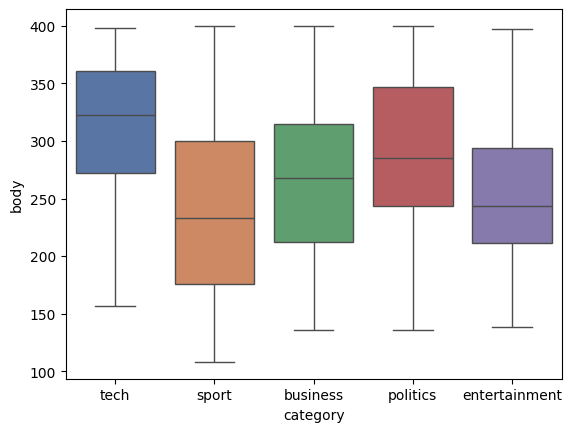

In [35]:
# Check for balance after filtering
import seaborn as sns
sns.boxplot(data=df_filtered, x='category', hue='category', y=df_filtered["body"].apply(lambda x : len(x.split())), palette='deep')